# Investigation on Hyperparameter Optimization in ML Regression Models
(Content extracted from UWLAX DS775 Fall 2020 lesson presentations, J. Baggett instructor)

## Introduction

- Fitting a model in machine learning is an optimization problem. 

- Optimization is used to find the regression model coefficients to minimize difference between observed and predicted values of the response variable.

- Most machine learning models also come with a bunch of parameters that need to be set which can alter the fit of the model. 

For example here is the LogisticRegression class from scikit learn (sklearn):
```
class sklearn.linear_model.LogisticRegression(penalty=’l2’, 
                                              dual=False, 
                                              tol=0.0001, C=1.0, 
                                              fit_intercept=True, 
                                              intercept_scaling=1, 
                                              class_weight=None, 
                                              random_state=None, 
                                              solver=’warn’, 
                                              max_iter=100, 
                                              multi_class=’warn’, 
                                              verbose=0, 
                                              warm_start=False, 
                                              n_jobs=None, 
                                              l1_ratio=None)
```

Some of these parameters have to do with exactly what model is fit. 

For instance, penalty changes the form of regularization added to the objective function to prevent overfitting while C changes the strength of the regularization (larger C is less regularization). 

These extra parameters are usually called hyperparameters and to get the best model they often need to be tuned. This tuning is another kind of optimization and is usually called "hyperparameter optimization" or "hyperparameter tuning". 

To keep everything straight it helps to remember that model parameters and hyperparameters are different. Hyperparameters are set or determined before the model is fit. Model parameters are determined during the process of fitting the model to the data.

Here are three kinds of hyperparameter optimization we'll explore:

### Grid Search
- Choose a list of possible values for each hyperparameter and loop over all the combinations of hyperparameters while fitting a model for each combination. 
- Return the combination that gives the best model performance. 
- We'll use GridSearchCV from the sklearn package.

### Random Search
- Choose a list of possible values, or a probability distribution, for each hyperparameter. 
- Choose combinations at random and return the combination that gives the best model performance. 
- We'll use RandomSearchCV from the sklearn package.

### Bayesian Optimization
- After each iteration an approximate model of the objective function, called a surrogate model, is built and used to suggest a better set of hyperparameters for the next iteration. 
- Surrogate models are really useful for objective functions that are expensive to evaluate and for which there is uncertainty or noise in the function values as there always will be when we sample data at random to feed into a machine learning model. 
- We'll use BayesianOptimization from the GPyOpt package. Other popular Python packages include HyperOpt and Scikit-Optimize. 

There are other hyperparameter optimization approaches, but Bayesian Optimization is currently the most popular. 


### Load imports

In [1]:
# computational imports
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.stats import uniform, randint
from GPyOpt.methods import BayesianOptimization
from tpot import TPOTRegressor
from pprint import pprint

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# for reading files from urls
import urllib.request
# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

# import warnings
import warnings

### Use Case Example: The Rastrigin Function

- The Rastrigin function is a common test case for optimization algorithms because it has many local minima.  
- We can use optimization methods such as Grid Search or Random Search to search thru the domain of the function to identify the optimial minimum of the function.
- The definition of the function is: 
$$f(\mathbf{x})=10 n+\sum_{i=1}^{n}\left[x_{i}^{2}-A \cos \left(2 \pi x_{i}\right)\right]$$
Where $n$ is the dimensionality of input vector $\mathbf{x}$.  
- For instance if $n=2$ then $\mathbf{x} = (x_1, x_2)$.  
- The domain is restricted so that each $x_i \in [-5.12, 5.12].$ .   

Here is a graph of the the Rastrigin function with dimension $n=1.$


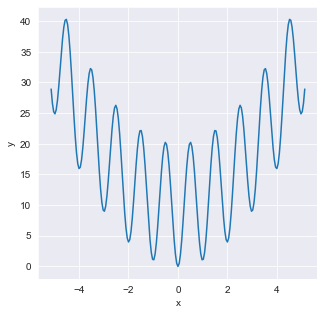

In [2]:
# Define the function
def rastrigin_1D(x):
    return (x**2 + 10 - 10 * np.cos(2 * np.pi * x))

x = np.linspace(-5.12,5.12,201)
y = rastrigin_1D(x)

fig = plt.figure(figsize=(5,5))
plt.plot(x,y)
plt.xlabel('x');
plt.ylabel('y');

### Load diabetes dataset

In [3]:
diabetes = load_diabetes()

### Partition the dataset

In [4]:
X = np.array(diabetes.data)
y = np.array(diabetes.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Define a scoring and visualization method

- When we apply the score() method to the test data it's no longer the value of r-squared that one has learned about in a statistics class. 
- This is because we are evaluating r-squared score on data that was not used to build the model but instead on test data. 
- For example, we can get a negative r-squared number which indicates that the model is performing worse, on the test data, than simply predicting that all of the target values are the same as the average target value.

In short, when we compute the r-squared score() for the test data:
- Values near one are great. 
- Values near zero just mean the model isn't really helping.
- Values that are negative mean that are model is worse than no model at all. 

This is the metric we will use to select our regression models so bigger positive values are better. 

Here is how we compute it:

In [5]:
def my_regression_results(model):
    score_test = model.score(X_test,y_test)

    y_pred = model.predict(X_test)
    # import matplotlib.pyplot as plt
    plt.figure(figsize=(9,6))
    plt.plot(y_test,y_pred,'k.')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');

    # from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)

    print('Model r-squared score from test data: {:0.4f}'.format(score_test))
    print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Root mean squared error on test data: {:0.2f}'.format(rmse))

### How do Non-Tuned Models Fare?

Let's first examine the prediction performance of three models (Linear Regression, Random Forest, and XGBoot) in which the hyperparameters are not tuned.

### Linear Regression (non-tuned)

The linear regression model uses a linear approach to model the relationship between a dependent variable and independent variables and is based on the equation y=ax+b.

Model r-squared score from test data: 0.5676
Mean squared error on test data: 2724.24
Root mean squared error on test data: 52.19


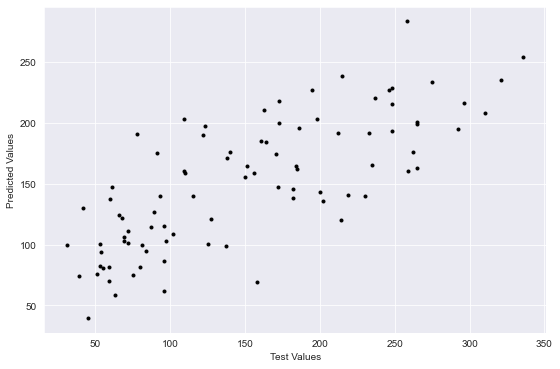

In [6]:
model_lr = LinearRegression()
model_lr.fit(X_train,y_train) 
my_regression_results(model_lr)

### Insight:

- You can interpret the rmse to roughly mean that the average error in our predictions is about 52.

### Random Forest Regression Model (non-tuned)

Random forest models are an ensemble learning method that constructs a multitude of decision trees a training time and then outputs the mean prediction for the individual trees as a group.

Model r-squared score from test data: 0.5368
Mean squared error on test data: 2918.49
Root mean squared error on test data: 54.02


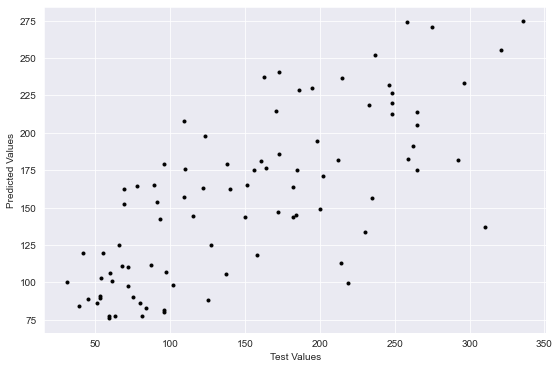

In [7]:
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train,y_train)
my_regression_results(rf_model)

### Insight:

The random forest model, with default parameters, is not as good as the linear regression model.

### XGBoost Model (non-tuned)

XGBoost is a decision-tree-based ensemble algorithm that uses a gradient boosting framework to produce some pretty fantastic results. XGBoost is typically quite a bit faster to train than a random forest algorithm, but can still be computationally expensive.

Model r-squared score from test data: 0.4590
Mean squared error on test data: 3408.14
Root mean squared error on test data: 58.38


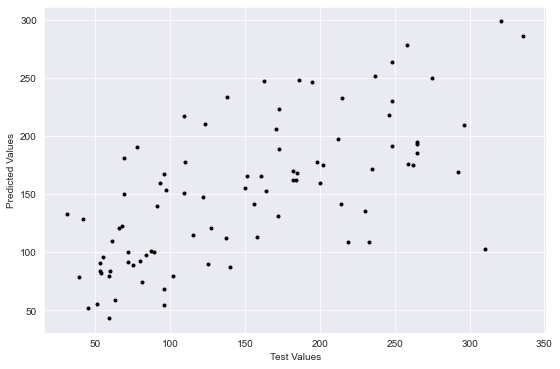

In [8]:
xgbr_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgbr_model.fit(X_train,y_train)
my_regression_results(xgbr_model)

### Non-Tuned Model Results Summary

```
                                         Linear_Regression    Random_Forest    XGBoost 
Model r-squared score from test data:       0.5676              0.5368          0.4590
Mean squared error on test data:           2724.24             2918.49         3408.14
Root mean squared error on test data:        52.19               58.38           54.02
```

Notice that the r-squared score in the XGBoost model is little lower than that of the random forest model, but not as high as for the linear regression model. The XGBoost model is slightly worst than than the random forest model, and is not as good as the linear regression model.

Our best model thus far is the linear regression model. 

Perhaps using the default hyperparameter values for training the other models wasn't the best choice. In what follows, we'll try to optimize improve xgboost model by tuning its parameters. 


### Hyperparameter Optimization applied to XGBoost Regression Model

Let's now examine and attempt to tune the hyperparameters of the XGBoost regression model using the discussed tuning methods.

In [9]:
# list XGBoot's hyperparameters 
pprint(xgbr_model.get_xgb_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}


### Identify Typical Ranges for Selected Hyperparameters

- Fortunately the default values shown above work pretty well in many problems.  
- Some of the hyperparameters don't directly change the model like `nthread` and `verbosity`.  
- Of the rest we'll pick a subset to optimize.  
- Some commonly optimized parameters are `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `min_child_weight` (these are the same ones that are optimized in the `TPOT` package). 
- Two other hyperparameters linked to regularization terms are `reg_lambda` and `reg_alpha` which can be useful to prevent overfitting.

The table below lists some typical values and default values:

Hyperparameter | Default Value | Typical Range
---- | ---- | ----
n_estimators | 100 | 10 to 100
max_depth | 3 | 1 to 10
min_child_weight | 1 | 1 to 20
learning_rate | 0.1 | 0.001 to 1
sub_sample | 1 | 0.05 to 1
reg_lambda | 1 | 0 to 5
reg_alpha  | 0 | 0 to 5

Of course, we could throw more hyperparameters into the mix, but we'll keep the numbers down to so we can afford to experiment.  

## Using GridSearchCV

The idea behind grid search is to pick a list of potential values for each hyperparameter and then search all the possible combinations doing a k-fold cross validation for each combination. 

That means we have to do k * number of combinations model fits. 

If we were to run this code:

```
params = {
    "learning_rate"    : [0.001, 0.01, 0.1, 0.5, 1.],
    "max_depth"        : np.arange(1,11),
    "n_estimators"     : [10,50,100],
    "subsample"        : np.arange(0.05,1.01,0.05),
    "min_child_weight" : np.arange(1,21),
    "reg_lambda"       : np.arange(0,.5,5.5),
    "reg_alpha"        : np.arange(0,.5,5.5)
}

grid_search = GridSearchCV(xgb_model, param_grid=params, cv=5, verbose=1, return_train_score=True)

grid_search.fit(X_train,y_train)
```

Then we would have $k=5$ and $5 \times 10 \times 3 \times 20 \times 20 \times 10 \times 10 = 6,000,000$ combinations for a total of 30,000,000 model fits. Even if we could fit 10 models per second, it would still take about 34 days to try all the models.  Nevertheless, GridSearchCV is commonly used by trimming the number of possible values for each parameter to get something manageable.

As you can see the lists or arrays of values for the hyperparameters are stored in a dictionary.  The number of cross-validation folds is set by `cv = 5`.

To illustrate how this works we'll pick fewer values for each hyperparameter as shown in the next cell, but we are still doing $2^6 \times 3 \times 5 = 960$ model fits which takes about a minute on my laptop:

### Tune with GridSearchCV method on the xgbr_model to find better hyperparameters

In [10]:
# define the grid
params = {
    "learning_rate"    : [0.01, 0.1],
    "max_depth"        : [2, 4, 6],
    "n_estimators"     : [10, 100],
    "subsample"        : [0.8, 1],
    "min_child_weight" : [1, 3],
    "reg_lambda"       : [1, 3],
    "reg_alpha:"       : [1, 3]
}

# setup the grid search
grid_search = GridSearchCV(xgbr_model,
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[18:13:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:13:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:13:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[18:13:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[18:13:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:13:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[18:13:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:13:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:13:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:13:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:13:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[18:13:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:13:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:13:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:13:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:14:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:14:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:14:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[18:14:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:14:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[18:14:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:14:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:14:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:14:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:14:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:14:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[18:14:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language

[18:14:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language


[18:14:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:14:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag


[18:14:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:14:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { reg_alpha: } might not be used.

  This may not be accurate due to some parameters are only used in languag

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   51.8s finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
      

### List the best hyperparameter values which are stored in the grid_search object as a dictionary:

In [11]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 3,
 'n_estimators': 100,
 'reg_alpha:': 1,
 'reg_lambda': 3,
 'subsample': 0.8}

### Score the Grid Search Tuned XGBoost Model

Model r-squared score from test data: 0.6157
Mean squared error on test data: 2421.23
Root mean squared error on test data: 49.21


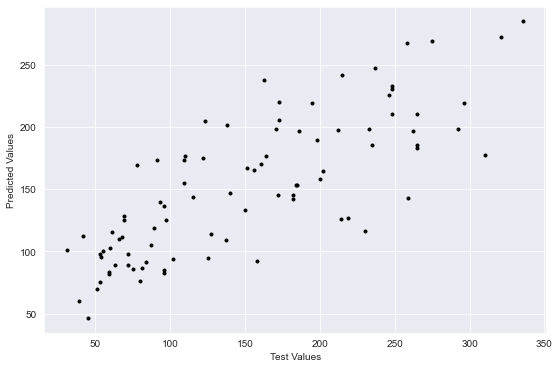

In [12]:
my_regression_results(grid_search)

### GridsearchCV Tuning Results Summary

```
                                         |---XGBoost Model -----|
TUNING                                   Non-Tuned    Grid_Search
Model r-squared score from test data:       0.4590       0.6157  
Mean squared error on test data:           3408.14      2421.23  
Root mean squared error on test data:        58.38        49.21  
Number of fits:                               0          960     
```

This is a nice improvement over the default XGBoost regression model. Our tuned model now performs better than the linear regression model we saw above.

The main drawback to grid search is that it can get really expensive if we want to exhaustively search, particularly if the model fits are slow as they can be when large datasets with many predictors are used.

### Tuning using RandomizedSearchCV

If we can only afford to fit the model a limited number of times, then one approach is to search randomly instead of exhaustively. 

To use RandomizedSearchCV we can either specify a probability distribution for each hyperparameter or we can specify a list of values for the hyperparameter in which case a value is chosen from the list assuming all values in the list are equally probable.

For optimizing our XGBoost model we'll leave the learning rate as a list since we want more small values to choose from than large values. The other hyperparameters can be specified with distributions. Note that the uniform distribution specified below is not intuitive. uniform(loc,scale) is uniform on the interval [loc, loc+scale]. For the search below we're going to check just 25 randomly selected sets of hyperparameters as we might for a really expensive model. random_state = 3 is a random number seed for reproducibility. Change it and you'll get different results.


In [13]:
# Train the model with hyperparameters using a Random Search tuning method
params = {
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.],
    "max_depth": randint(1, 10),
    "n_estimators": randint(10, 100),
    "subsample": uniform(0.05, 0.95),  # so uniform on [.05,.05+.95] = [.05,1.]
    "min_child_weight": randint(1, 20),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5)
}

random_search = RandomizedSearchCV(
    xgbr_model,
    param_distributions=params,
    random_state=8675309,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    3.2s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_par...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022A863D9E20>,
               

### List the optimized hyperparameters that the Random Search tuning method identified

In [14]:
random_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 7,
 'n_estimators': 82,
 'reg_alpha': 0.30321968913636976,
 'reg_lambda': 2.1414785142199557,
 'subsample': 0.1011386086671309}

### Score the Random Search Tuned XGBoost Model

Model r-squared score from test data: 0.5547
Mean squared error on test data: 2805.16
Root mean squared error on test data: 52.96


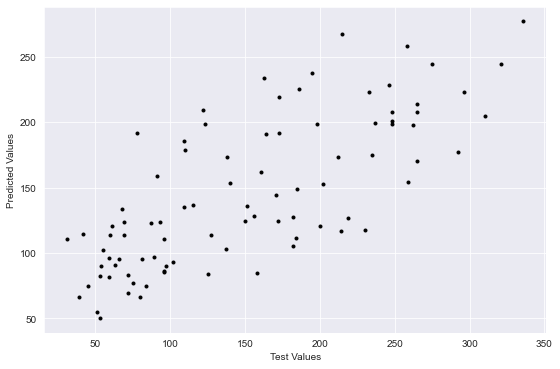

In [15]:
my_regression_results(random_search)

### RandomSearchCV Tuning Results Summary

```
                                         |---XGBoost Model ---------------------|
TUNING                                   Non-Tuned    Grid_Search   Random_Search
Model r-squared score from test data:       0.4590       0.6157         0.5547   
Mean squared error on test data:           3408.14      2421.23        2805.16   
Root mean squared error on test data:        58.38        49.21          52.96   
Number of fits:                               0          960            125      
```

The random search found results that were not quite as good as those found with the grid search, but with far fewer model fits.


### Using BayesianOptimization from GPyOpt

On average Bayesian optimization does better than random search.  It especially excels when there are lots of hyperparameters, but it won't beat random search every time.  The power of Bayesian optimization is that it can often achieve good results with a relatively short number of training iterations.  

The setup is a bit more complicated.  We start by specifying the bounds as a list of dictionaries.  For each hyperparameter we give a name, the type, and the range.  If you want to use strings or non-equally space values then you have to work a bit harder, but we shouldn't need that for this project.

The function `cv_score()` receives a nested list with hyperparameter values that we use to setup the model.  We have to manually map the hyperparameter values to their places in the model declaration as shown below.  `cv_score` returns the 5-fold cross-validated estimate of the model score.  

In essence `cv_score()` is just like `rastrigin(x)` or any other objective function.  We now pass the name of the objective function to our optimization routine.  To make this comparable to the random search we want to do 25 iterations resulting in 125 model fits, but we've declared the number of iterations to be 20 since `BayesianOptimization` starts by training the model at 5 random sets of hyperparameter values.  


In [16]:
np.random.seed(8675309)  # seed courtesy of Tommy Tutone


hp_bounds = [{
    'name': 'learning_rate',
    'type': 'continuous',
    'domain': (0.001, 1.0)
}, {
    'name': 'max_depth',
    'type': 'discrete',
    'domain': (1, 10)
}, {
    'name': 'n_estimators',
    'type': 'discrete',
    'domain': (10, 100)
}, {
    'name': 'subsample',
    'type': 'continuous',
    'domain': (0.05, 1.0)
}, {
    'name': 'min_child_weight',
    'type': 'discrete',
    'domain': (1, 20)
}, {
    'name': 'reg_alpha',
    'type': 'continuous',
    'domain': (0, 5)
}, {
    'name': 'reg_lambda',
    'type': 'continuous',
    'domain': (0, 5)
}]

# Optimization objective
def cv_score(hyp_parameters):
    hyp_parameters = hyp_parameters[0]
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 learning_rate=hyp_parameters[0],
                                 max_depth=int(hyp_parameters[1]),
                                 n_estimators=int(hyp_parameters[2]),
                                 subsample=hyp_parameters[3],
                                 min_child_weight=int(hyp_parameters[4]),
                                 reg_alpha=hyp_parameters[5],
                                 reg_lambda=hyp_parameters[6])
    scores = cross_val_score(xgb_model,
                             X=X_train,
                             y=y_train,
                             cv=KFold(n_splits=2))
    
    return np.array(scores.mean())  # return average of 5-fold scores


optimizer = BayesianOptimization(f=cv_score,
                                 domain=hp_bounds,
                                 model_type='GP',
                                 acquisition_type='EI',
                                 acquisition_jitter=0.05,
                                 exact_feval=True,
                                 maximize=True,
                                 verbosity=True)

optimizer.run_optimization(max_iter=2,verbosity=True)

num acquisition: 1, time elapsed: 0.38s
num acquisition: 2, time elapsed: 0.71s


### Extract the hyperparameter values

The RandomSearchCV and GridSearchCV classes both contain the model as attributes so we could just call the score() and predict() methods, but for BayesianOptimization we'll have to extract the coefficients and use them to build the optimized model. 

This is a bit fancy, but it allows us to efficiently construct the model without cutting and pasting or retyping. First we'll create a dictionary containing the optimized hyperparameter values:
    

In [17]:
best_hyp_set = {}
for i in range(len(hp_bounds)):
    if hp_bounds[i]['type'] == 'continuous':
        best_hyp_set[hp_bounds[i]['name']] = optimizer.x_opt[i]
    else:
        best_hyp_set[hp_bounds[i]['name']] = int(optimizer.x_opt[i])
best_hyp_set

{'learning_rate': 0.12183284948100732,
 'max_depth': 1,
 'n_estimators': 100,
 'subsample': 0.31779897795352685,
 'min_child_weight': 20,
 'reg_alpha': 3.6014342172321645,
 'reg_lambda': 1.9640072083476605}

Then we can pass the dictionary directly to the model constructor as shown below. Once we created an instance of the model we also train it:

In [18]:
# train the model

bayopt_search = xgb.XGBRegressor(objective='reg:squarederror',**best_hyp_set)
bayopt_search.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.12183284948100732, max_delta_step=0, max_depth=1,
             min_child_weight=20, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=3.6014342172321645, reg_lambda=1.9640072083476605,
             scale_pos_weight=1, subsample=0.31779897795352685,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Score the Bayesian Optimization Tuned XGBoost Model

Model r-squared score from test data: 0.5879
Mean squared error on test data: 2596.35
Root mean squared error on test data: 50.95


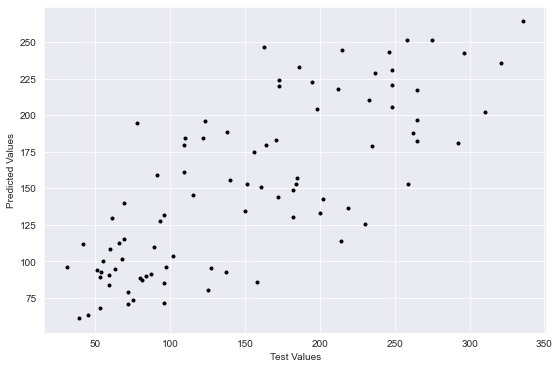

In [19]:
my_regression_results(bayopt_search)

### Bayesian Optimization Tuning Results Summary

```
                                         |---XGBoost Model ---------------------------------|
TUNING                                  Non-Tuned    Grid_Search   Random_Search    Bayesian
Model r-squared score from test data:       0.4590       0.6157         0.5547        0.5879 
Mean squared error on test data:           3408.14      2421.23        2805.16       2596.35 
Root mean squared error on test data:        58.38        49.21          52.96         50.95 
Number of fits:                               0          960            125           125    
```

Depending on the random seeds you've used you might see that Bayesian Optimization does better or worse than Random Search. (Try a few different seeds and compare. Warning - we've not been able to figure out why Bayesian Optimization gives different results with the same seed if you restart your kernel.) However, for both the random search and for the Bayesian optimization we've done only 125 model fits as opposed to the 960 we did for grid search.

Both random search and Bayesian optimization will give better results if they're allowed to fun for more iterations. Bayesian optimization doesn't always beat random search, but common wisdom suggests that it usually works better - see this Stack Exchange post for some nice discussion and references. Moreover companies are getting into automatic machine learning in a big way and some of the giants, like Google, are betting on Bayesian Optimization.


### Using TPOT with Optimized Hyperparameters

TPOT can actually do much more than optimize hyperparameters for a single model, but it can do that too. To focus on a single model we set up a nested dictionary like that shown in the code below. Then we call TPOT and it returns an optimized model in an object that behaves just like objects returned by GridSearchCV and RandomSearchCV. Additional models could be added as 'model_name':{'param':values,'param':value,...}.


In [20]:
tpot_config = {
    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'reg_alpha': range(1, 6),
        'reg_lambda': range(1, 6),
        'nthread': [1],
        'objective': ['reg:squarederror']
    }
}

tpot = TPOTRegressor(scoring = 'r2',
                     generations=5,
                     population_size=20,
                     verbosity=2,
                     config_dict=tpot_config,
                     cv=5,
                     random_state=8675309)
tpot.fit(X_train, y_train)
# tpot.export('tpot_XGBregressor.py') # export the model


Version 0.11.5 of tpot is outdated. Version 0.11.6 was released 7 days ago.



Generation 1 - Current best internal CV score: 0.41473424593500796
Generation 2 - Current best internal CV score: 0.41539686865502573
Generation 3 - Current best internal CV score: 0.41539686865502573
Generation 4 - Current best internal CV score: 0.41539686865502573
Generation 5 - Current best internal CV score: 0.4365513495756462
Best pipeline: XGBRegressor(CombineDFs(input_matrix, input_matrix), learning_rate=0.1, max_depth=1, min_child_weight=2, n_estimators=100, nthread=1, objective=reg:squarederror, reg_alpha=3, reg_lambda=2, subsample=0.5)


TPOTRegressor(config_dict={'xgboost.XGBRegressor': {'learning_rate': [0.001,
                                                                      0.01, 0.1,
                                                                      0.5,
                                                                      1.0],
                                                    'max_depth': range(1, 11),
                                                    'min_child_weight': range(1, 21),
                                                    'n_estimators': [100],
                                                    'nthread': [1],
                                                    'objective': ['reg:squarederror'],
                                                    'reg_alpha': range(1, 6),
                                                    'reg_lambda': range(1, 6),
                                                    'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
 

### Score the TPOT Tuned XGBoost Model

Model r-squared score from test data: 0.5928
Mean squared error on test data: 2565.19
Root mean squared error on test data: 50.65


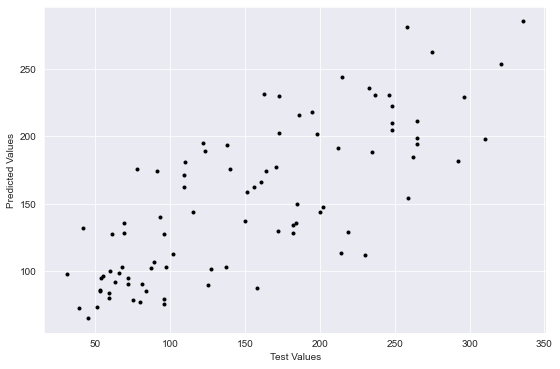

In [21]:
# We can display the results on the test data in the same way as with our other models.
my_regression_results(tpot)

### TPOT Tuning Results Summary

```
                                         |---XGBoost Model ---------------------------------------------|
TUNING                                   Non-Tuned    Grid_Search   Random_Search    Bayesian        TPOT
Model r-squared score from test data:       0.4590       0.6157         0.5547        0.5879       0.5928
Mean squared error on test data:           3408.14      2421.23        2805.16       2596.35      2565.19
Root mean squared error on test data:        58.38        49.21          52.96         50.95        50.65
Number of fits:                               0          960            125           125          600   
```

We've found that we generally need more model fits to get good results with TPOT than we did with Bayesian Optimization, but it still works really well. 

Note that TPOT is maximizing the k-fold cross-validated negative mean square error instead of r-squared, but it gets us to the same place. 

Here we iterate for 5 generations with 20 different individual sets of hyperameters in each generation. For each individual we do 5 model fits (k = 5) and there is an extra round of cross validated fits for the initial population, thus altogether we perform  6×20×5=600  model fits.


### Using TPOT to Pick the Best ML Model and Hyperparameter Set (AutoML)

We've actually used TPOT in a rather narrow way by forcing it to optimize the hyperparameters for one choice of a machine learning model. However, TPOT is really designed as an auto machine learning tool (AutoML) that tries to figure out optimize the whole machine learning pipeline: data preprocessing, feature selection, model selection, and hyperparamter tuning. For real problems this process could take days (see the TPOT discussion of AutoML. For this toy problem it doesn't take too long so let's see what it does.

By specifying None for the config_dict parameter TPOT defaults to optimizing the whole hyperparameter set within the machine learning pipeline. We'll turn it loose with a population size of 40 for 10 generations which will require 2400 model fits.


In [ ]:
# from tpot import TPOTRegressor
tpot_ml = TPOTRegressor(scoring = 'r2',
                     generations=10,
                     population_size=40,
                     verbosity=2,
                     cv=5,
                     random_state=8675309)
tpot_ml.fit(X_train, y_train)

print("\n\ntpotML Score = ", tpot_ml.score(X_test, y_test))

Version 0.11.5 of tpot is outdated. Version 0.11.6 was released 7 days ago.



Generation 1 - Current best internal CV score: 0.4577901475756866

### Score the Automated TPOT ML Model

In [ ]:
my_regression_results(tpot_ml)

### Conclusions

```
                                         |---XGBoost Model ---------------------------------------------|    LassoLarsCV
                                         Non-Tuned    Grid_Search   Random_Search    Bayesian        TPOT    TPOT_ML
Model r-squared score from test data:       0.4590       0.6157         0.5547        0.5879       0.5928     0.5772
Mean squared error on test data:           3408.14      2421.23        2805.16       2596.35      2565.19     2663.88
Root mean squared error on test data:        58.38        49.21          52.96         50.95        50.65       51.61
Number of fits:                                          960            125           125          600        2400
```


After exploring several different hyperparameter optimization tools, we found that all of them improved the XGBregressor model by varying amounts. 

Looking just at the hyperparameter optimization of the xgbr_model we found that GridSearchCV was the most expensive with 960 model fits, but it found a very good model. 

RandomSearchCV and BayesianOptimizaion both used 125 model fits.

GridSearchCV identified the model with the lowest MSE on the test data; while the TPOT model produced the lowest rmse value.

Note that although the Bayesian Optimization model outperforms Random Search model, if you change the random number seeds, then you'll get different results and Bayesian Optimization model may not always be the winner. 

However, the consensus is that Bayesian Optimization works better than Random Search on average.
